### "Numerical optimization and large scale linear algebra"

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.linalg import svd, norm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

### Classification of Handwritten Digits

#### Read the file hand_written_class.pdf. Construct an algorithm for classification of handwritten digits. Using a training set, and compute the SVD of each class matrix. Use the first few (5-20) singular vectors as basis and classify unknown test digits according to how well they can be represented in terms of the respective bases (use the relative residual vector in the lest squares problem as a measure).

### Specific Tasks

#### 1. Tune the algorithm for accuracy of classification. Give a table or graph of the percentage of correctly classified digits as a function of the number of basis vectors. 

Based on the "Matrix Methods in Data Mining and Pattern Recognition" paper, some specific steps have to be applied to compute the SVD of each class matrix and then classify the unknown test digits.

To compute the SVD of each class we need to construct the matrix A of each class in which the SVD will be applied. Matrix A consists of 10 lists that each one of them contains the matrix $A_i$. Each matrix $A_i$ has 256 rows (16x16 pixels) and as columns the number of samples in each class. For example the matrix $A_1$ has as many columns as the number of images classified as 1 in 'ytrain' DataFrame.

The goal is to create a matrix with lower rank than A by keeping a specific number of basis vectors that have the highest signular values. The matrices U,S,V for each class are calculated through SVD for each A matrix. The S matrix contains the singular values, while the U matrix is contructed from the eigenvectors of $AA^T$ and is called left singular vector.

The left signular vectors from each U matrix represent a specific digit and based on that, an unknown image from test set can be classified as a specific digit. The first singular vectors contain more information in each U. The concept is to use only some of these singular vectors and maintain a satisfactory representation of the initial one.

It can be computed how well an unknow number is represented in each different class by computing the norm of the residual vector in least squares problem 
$||(I-U_k U_k^T)z||_2$ where z is the digit that needs to be classified. Hence, for an unknown digit, 10 residual errors will be computed for each different $U_i$ and we classify the digit as the one with the lowest residual.

In [87]:
#Import the data from each excel spreadsheet in xtrain,ytrain,xtest,ytest

os.chdir(r'C:\Users\add_path')  #Add path
ytest=pd.read_excel('data.xlsx',sheet_name='dtest',header=None)
ytrain=pd.read_excel('data.xlsx',sheet_name='dzip',header=None)
xtrain=pd.read_excel('data.xlsx',sheet_name='azip',header=None)
xtest=pd.read_excel('data.xlsx',sheet_name='testzip',header=None)

In [88]:
# Create matrix A which contains 10 matrices, each one of them corresponding to matrix Ai where i=0,..,9 classes
#Each matrix Ai has 256 rows
#Matrix A1 contains images that are classified only as 1 in ytrain etc.

A=[]
for i in range(10):
    A.append(xtrain.loc[:,ytrain.iloc[0,:]==i])

In [89]:
#Calculate U,S,V by applying SVD in each one of the Ai
#Again each of U,S,V contain Ui,Si,Vi for each one of the classes

U=[]
S=[]
V=[]
for i in range(10):
    u,s,v=svd(A[i],full_matrices=False)
    U.append(u)
    S.append(s)
    V.append(v)

In [90]:
#Define function which takes the minimum and maximum value of k
#Calculate Identity matrix as I
#For each number of basis vectors calculate the norm of residual error (||I-UU^T||)
#Classify the digit as the one with the lowest residual
#predK contains the predictions for each different number of singular vectors

def clf(kmin,kmax):
    I=np.eye(len(xtest))
    predK=pd.DataFrame()
    for k in range(kmin,kmax):
        pred=[]
        for i in range(len(xtest.columns)):
            residuals=[]
            for j in range(10):
                u=U[j][:,:k]
                residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
            minres=np.argmin(residuals)
            pred.append(minres)
        pred=pd.DataFrame(pred)
        predK[str(k)]=pred
    return predK

#Run function clf

predK=clf(5,21)

In [91]:
#Calculate the accuracy of predictions for each different number of singular vectors

accuracyK=pd.DataFrame()
for k in range(5,21):
    accuracy=accuracy_score(ytest.iloc[0,:],predK[str(k)])
    accuracyK['k='+str(k)]=[accuracy]
    
print(accuracyK)

       k=5       k=6       k=7       k=8       k=9      k=10      k=11  \
0  0.90284  0.905331  0.916791  0.920279  0.926258  0.931739  0.932237   

       k=12      k=13      k=14      k=15      k=16      k=17      k=18  \
0  0.935725  0.936223  0.939213  0.941206  0.938714  0.939213  0.941704   

       k=19      k=20  
0  0.940708  0.939711  


Text(0.5, 0, 'k: number of singular vectors')

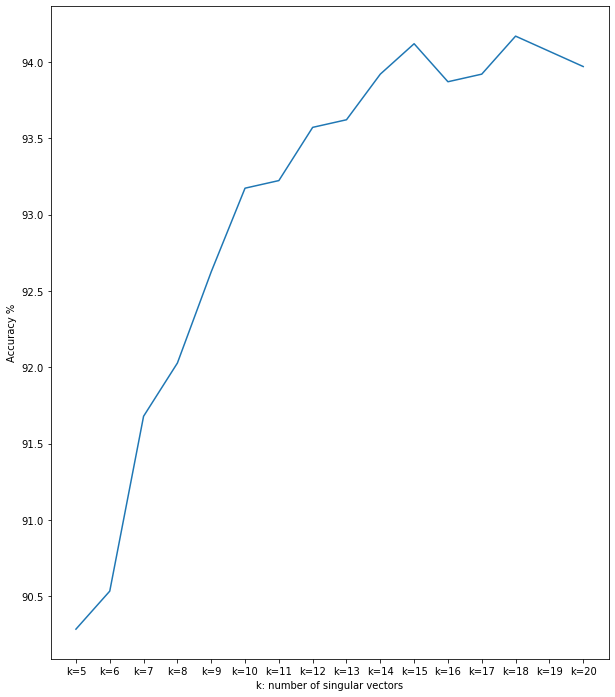

In [92]:
#Plot the accuracy for each different numbe of singular vectors

plt.figure(figsize=(10,12))
plt.plot(accuracyK.columns,accuracyK.iloc[0,:]*100)
plt.ylabel('Accuracy %')
plt.xlabel('k: number of singular vectors')

In [93]:
#Confusion matrix for the best k
#Columns show the predicted class
#Rows show the true class

print(confusion_matrix(ytest.iloc[0,:], predK.iloc[:,np.argmax(accuracyK)]))

[[355   0   2   0   1   0   0   0   0   1]
 [  0 259   0   0   3   0   2   0   0   0]
 [  8   1 178   2   5   0   0   1   3   0]
 [  2   0   3 150   1   6   0   1   2   1]
 [  2   1   0   0 185   2   0   3   0   7]
 [  7   1   1   5   0 141   0   0   2   3]
 [  2   1   0   0   2   1 163   0   1   0]
 [  0   1   1   0   3   0   0 141   0   1]
 [  2   0   1   6   0   1   0   0 153   3]
 [  0   2   0   1   4   0   0   3   2 165]]


In [94]:
#Classification report for the best k

print(classification_report(ytest.iloc[0,:], predK.iloc[:,np.argmax(accuracyK)]))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       359
           1       0.97      0.98      0.98       264
           2       0.96      0.90      0.93       198
           3       0.91      0.90      0.91       166
           4       0.91      0.93      0.92       200
           5       0.93      0.88      0.91       160
           6       0.99      0.96      0.97       170
           7       0.95      0.96      0.95       147
           8       0.94      0.92      0.93       166
           9       0.91      0.93      0.92       177

    accuracy                           0.94      2007
   macro avg       0.94      0.94      0.94      2007
weighted avg       0.94      0.94      0.94      2007



The results suggest that the higher classification accuracy of 94% is achieved by using the first 18 basis singular vectors. This can be also confirmed by the plot of accuracy for different k. The classification report for the best k=18 shows that the f1-score=0.94. The classes with the highest f1-scores are digits 1 and 6 with f1-score 0.98 and 0.97 respectively, while the worst are digits 3 and 5 with f1-score=0.91

#### 2. Check if all digits are equally easy or difficult to classify. Also look at some of the difficult ones, and see that in many cases they are very badly written.

Based on confussion matrix and classification report the most difficult digits to classify are 3 and 5 with f1-score of 91% followed by 4 and 9 with f1-score of 92%. Therefore, some misclassied numbers will be plotted, followed by plots for digit 3 and 5 that had the worst f1-score.

In [95]:
#Create the function ima2.n that displays the digits

def ima2(A):
    image=np.array(A)
    image=image.reshape(16,16)
    plt.imshow(image)

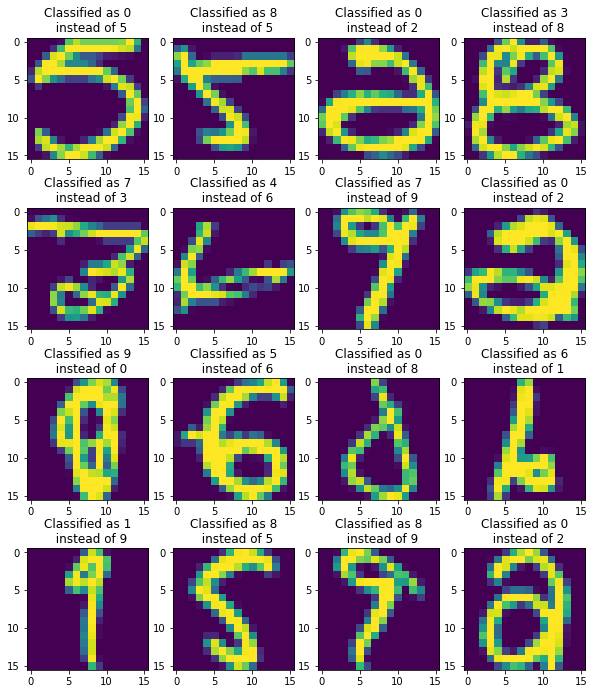

In [96]:
#Array misclass contains the indexes of wrongly classified digits

misclass=np.where(ytest.iloc[0,:]!=predK.iloc[:,13])

#Plot the first 16 digits that were wrongly classified

plt.figure(figsize=(10,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    ima2(xtest.iloc[:,misclass[0][i]])
    plt.title('Classified as '+str(predK.iloc[misclass[0][i],13]) +'\n '+' instead of '+str(ytest.iloc[0,misclass[0][i]]))

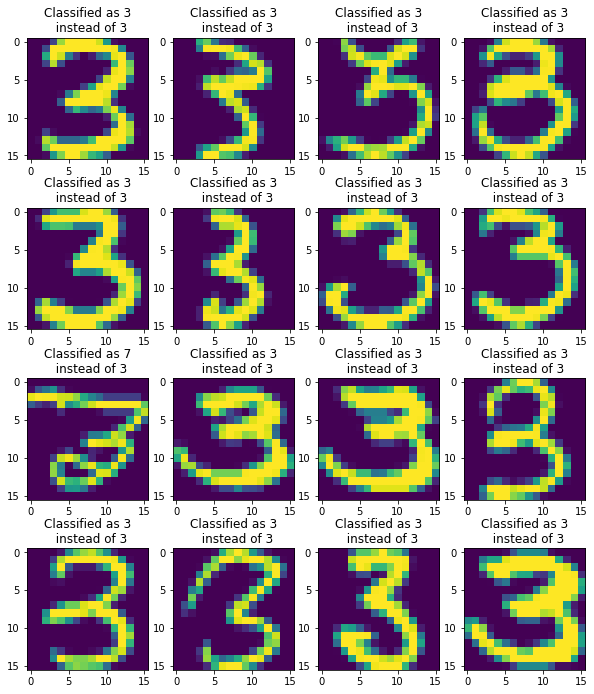

In [97]:
#Array class3 contains the indexes of the three digit

class3=np.where(ytest.iloc[0,:]==3)

#Plot the first 16 digits that were the digit 3

plt.figure(figsize=(10,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    ima2(xtest.iloc[:,class3[0][i]])
    plt.title('Classified as '+str(predK.iloc[class3[0][i],13]) +'\n '+' instead of '+str(ytest.iloc[0,class3[0][i]]))

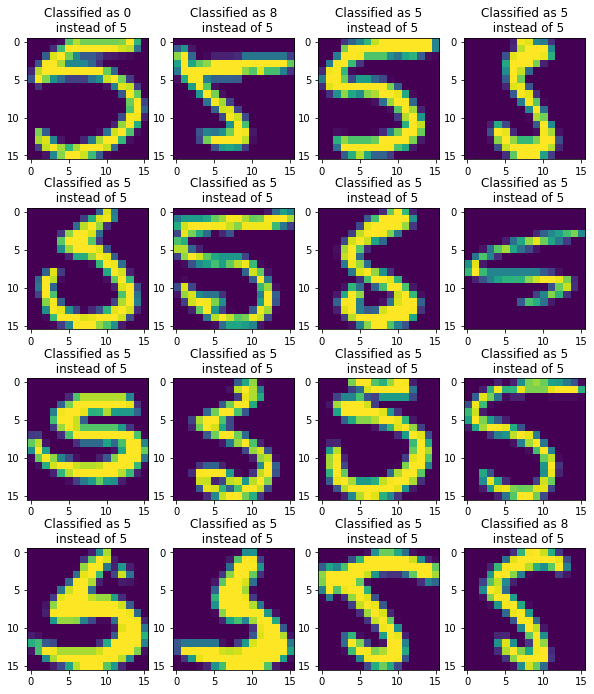

In [98]:
#Array class5 contains the indexes of the five digit

class5=np.where(ytest.iloc[0,:]==5)

#Plot the first 16 digits that were the digit 5

plt.figure(figsize=(10,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    ima2(xtest.iloc[:,class5[0][i]])
    plt.title('Classified as '+str(predK.iloc[class5[0][i],13]) +'\n '+' instead of '+str(ytest.iloc[0,class5[0][i]]))

Indeed, we observe that the digits that were wrongly classified were poorly written.

#### 3. Check the singular values of the different classes. Is it motivated to use different numbers of basis vectors for different classes? If so, perform a few experiments to find out if it really pays off to use fewer basis vectors in one or two of the classes. 

We observe that the first singular values in some $U_i$ are much bigger than the others, which means that some classes could keep only the first singular vectors and maintain most of the necessary information. By doing this we could use fewer singular vectors and maintain or even increase the accuracy of the classification. The initial guess is that classes with better results in classification like digits zero and one could use less singular vectors and keep their efficiency because their first few singular values are way bigger that the others.

To test this hypothesis, the same process as question 1 is followed. The basis vector number k=18 is used as it produces the best results. The differece is that we test different number of singular vectors only for digits zero and one.

First, we test the hypothesis only for digit zero, then for digit one and finally for both digits. The results suggest that if we use k=18 for all digits and k=16 for digit zero we get the highest accuracy. The same applies for k=11 if we change the number of singular vectors of digit one and for k=13 if we change the number of singular vectors of digit one and zero.

In [99]:
# Check the first singular values

for i in range(10):
    print('Singular values for class'+str(i)+'\n',S[i][:10])

Singular values for class0
 [184.44749844  97.59388422  62.05061337  54.14931248  41.06020067
  40.36847138  36.28294233  30.02308652  29.00107349  24.94954536]
Singular values for class1
 [234.04151731  41.9309063   24.84924265  16.29480667  13.61095501
  12.52178131  11.22883717  10.66849318   8.4133817    8.32127045]
Singular values for class2
 [138.2836996   57.39739384  46.39569635  40.96003126  37.50530652
  33.53160003  32.237997    28.40611951  27.12012507  26.73498766]
Singular values for class3
 [126.63823606  39.77367291  33.32245701  29.87372361  27.9646299
  24.76781289  24.39030584  21.460863    19.05978766  18.59508072]
Singular values for class4
 [123.02706507  41.62602412  34.93431159  32.29075793  26.81182829
  24.5655462   21.86754262  20.44929199  20.08172813  18.45554627]
Singular values for class5
 [94.28412631 37.85299086 35.77494073 28.02067178 24.0466634  22.43784723
 20.63123172 20.36365239 17.06151968 16.81156101]
Singular values for class6
 [141.95961664  52

In [100]:
#For each number of basis vectors calculate the norm of residual error (||I-UU^T||) for digit ZERO
#Classify the digit as the one with the lowest residual
#predKzero contains the predictions for each different number of singular vectors for digit ZERO, while all the other digits have k=18

predKzero=pd.DataFrame()
for k in range(1,19):
    pred=[]
    for i in range(len(xtest.columns)):
        residuals=[]
        for j in range(10):
            if j==0:
                u=U[j][:,:k]
                residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
            else:
                u=U[j][:,:18]
                residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
        minres=np.argmin(residuals)
        pred.append(minres)
    pred=pd.DataFrame(pred)
    predKzero[str(k)]=pred

In [101]:
#Calculate the accuracy of predictions for each different number of singular vectors for digit zero while all the other digits have k=18

accuracyKzero=pd.DataFrame()
for k in range(1,19):
    accuracy=accuracy_score(ytest.iloc[0,:],predKzero[str(k)])
    accuracyKzero['k='+str(k)]=[accuracy]
    
print(accuracyKzero)

print('\n The optimal k for digits zero is',np.argmax(accuracyKzero)+1)

        k=1       k=2       k=3       k=4       k=5       k=6       k=7  \
0  0.801196  0.855007  0.889387  0.909317  0.918286  0.927255  0.931241   

       k=8      k=9      k=10      k=11      k=12      k=13      k=14  \
0  0.93423  0.93722  0.938216  0.942202  0.942701  0.943199  0.942701   

       k=15      k=16      k=17      k=18  
0  0.943199  0.943697  0.943697  0.941704  

 The optimal k for digits zero is 16


In [102]:
#For each number of basis vectors calculate the norm of residual error (||I-UU^T||) for digit ONE
#Classify the digit as the one with the lowest residual
#predKone contains the predictions for each different number of singular vectors for digit ONE, while all the other digits have k=18

predKone=pd.DataFrame()
for k in range(1,19):
    pred=[]
    for i in range(len(xtest.columns)):
        residuals=[]
        for j in range(10):
            if j==1:
                u=U[j][:,:k]
                residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
            else:
                u=U[j][:,:18]
                residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
        minres=np.argmin(residuals)
        pred.append(minres)
    pred=pd.DataFrame(pred)
    predKone[str(k)]=pred

In [103]:
#Calculate the accuracy of predictions for each different number of singular vectors for digit one while all the other digits have k=18

accuracyKone=pd.DataFrame()
for k in range(1,19):
    accuracy=accuracy_score(ytest.iloc[0,:],predKone[str(k)])
    accuracyKone['k='+str(k)]=[accuracy]
    
print(accuracyKone)

print('\n The optimal k for digit one is',np.argmax(accuracyKone)+1)

        k=1       k=2       k=3       k=4       k=5      k=6       k=7  \
0  0.921276  0.932237  0.934728  0.935725  0.936721  0.93722  0.939711   

        k=8       k=9      k=10      k=11      k=12      k=13      k=14  \
0  0.941704  0.941206  0.941704  0.942202  0.942202  0.942202  0.942202   

       k=15      k=16      k=17      k=18  
0  0.942202  0.942202  0.941704  0.941704  

 The optimal k for digit one is 11


In [104]:
#For each number of basis vectors calculate the norm of residual error (||I-UU^T||) for digit ONE and ZERO
#Classify the digit as the one with the lowest residual
#predKone_zero contains the predictions for each different number of singular vectors for digit ONE and ZERO, while all the other digits have k=18

predKone_zero=pd.DataFrame()
for k in range(1,19):
    pred=[]
    for i in range(len(xtest.columns)):
        residuals=[]
        for j in range(10):
            if j==1:
                u=U[j][:,:k]
                residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
            elif j==0:
                u=U[j][:,:k]
                residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
            else:
                u=U[j][:,:18]
                residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
        minres=np.argmin(residuals)
        pred.append(minres)
    pred=pd.DataFrame(pred)
    predKone_zero[str(k)]=pred

In [105]:
#Calculate the accuracy of predictions for each different number of singular vectors for digit one and zero while all the other digits have k=18

accuracyKone_zero=pd.DataFrame()
for k in range(1,19):
    accuracy=accuracy_score(ytest.iloc[0,:],predKone_zero[str(k)])
    accuracyKone_zero['k='+str(k)]=[accuracy]
    
print(accuracyKone_zero)

print('\n The optimal k for digits zero and one is',np.argmax(accuracyKone_zero)+1)

        k=1       k=2       k=3       k=4       k=5      k=6       k=7  \
0  0.780767  0.845541  0.882412  0.903338  0.913303  0.92277  0.929248   

       k=8       k=9      k=10      k=11      k=12      k=13      k=14  \
0  0.93423  0.937718  0.939213  0.943697  0.943697  0.944195  0.943697   

       k=15      k=16      k=17      k=18  
0  0.944195  0.944195  0.943697  0.941704  

 The optimal k for digits zero and one is 13


### Optional Tasks

#### TWO-STAGE ALGORITHM WITH SVD
#### In order to save operations in the test phase, implement a two-stage algorithm: In the first stage compare the unknown digit only to the first singular vector in each class. If for one class the residual is significantly smaller than for the others, classify as that class. Otherwise perform the algorithm above. Is it possible to get as good results for this variant? How frequently is the second stage unnecessary?


It seems that the results are not satisfactory comparing to different number of singular vectors. The accuracy of this methodology is 80% and the second stage is necessary 4 times.

In [106]:
predKoptional=pd.DataFrame()
pred=[]

#Tolerance of the significance of residuals
tol=0.005

#Number of second stages
count=0

#Two-stage algorithm
for i in range(len(xtest.columns)):
    residuals=[]
    for j in range(10):
        u=U[j][:,:1]                                                               #Use one singular vector
        residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
    if sorted(residuals)[1]-sorted(residuals)[0]<tol:
        residuals=[]
        count=count+1
        for n in range(10):
            u=U[j][:,:18]                                                         #Use 18 singular vectors in second stage if necessary
            residuals.append(norm(np.dot(I-np.dot(u,u.T),xtest.iloc[:,i]),2))
    minres=np.argmin(residuals)
    pred.append(minres)
pred=pd.DataFrame(pred)
predKoptional=pred

In [107]:
#Calculate the accuracy of predictions

accuracy=accuracy_score(ytest.iloc[0,:],predKoptional)
    
print('The accuracy is ',accuracy*100, '%')
print('The number that the second stage is necessary is',count)

The accuracy is  80.11958146487295 %
The number that the second stage is necessary is 4
